In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from collections import Counter
from itertools import product

from imblearn.over_sampling import SMOTE 

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

C:\Users\JYM\AppData\Local\Temp/ipykernel_28452/2270551363.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_28452/2270551363.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [4]:
# some cleaning just ot make sure
train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

In [5]:
%%time
X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

Wall time: 54.1 s


### NAIVE BAYES

In [6]:
%%time
sample_size = 100000 # 150000
chi2_features = 25000 # 27500
alpha =  0.001
fit_prior =  True
class_prior =  None


train_df_sample = train_df.sample(sample_size).copy()
            
X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train = train_df_sample['debt_collection']

selector = SelectKBest(chi2, k=chi2_features)
X_train = selector.fit_transform(X_train, y_train)
# Transform dev set with the same selector
X_dev_transformed = selector.transform(X_dev)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf = naive_bayes.MultinomialNB(
                    alpha=alpha, 
                    fit_prior=fit_prior, 
                    class_prior=class_prior
                )
clf.fit(X_train, y_train)

Wall time: 19.8 s


MultinomialNB(alpha=0.001)

Train
accuracy_score 0.9030559570514144
balanced_accuracy_score 0.9030559570514145
average_precision_score 0.8614166707123153
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     82331
           1       0.90      0.91      0.90     82331

    accuracy                           0.90    164662
   macro avg       0.90      0.90      0.90    164662
weighted avg       0.90      0.90      0.90    164662

Prediction [(1, 83652), (0, 81010)]
Ground Truth [(0, 82331), (1, 82331)]


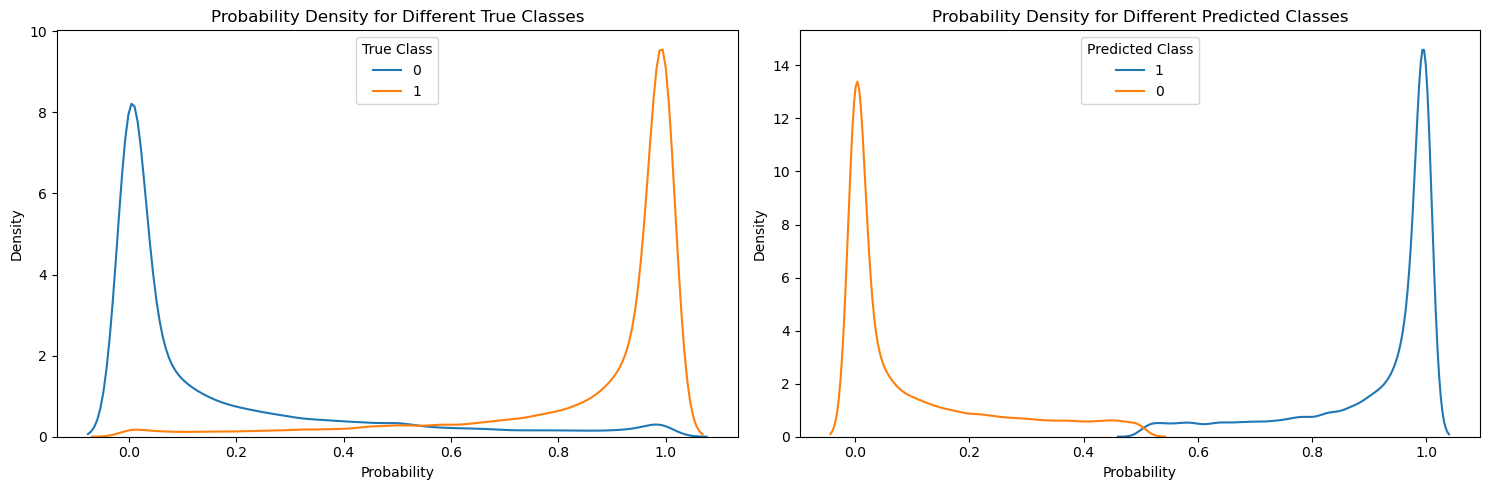

In [7]:
# get the results
y_pred = clf.predict(X_train.toarray())
y_pred_proba = clf.predict_proba(X_train.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train, y_pred))
print("average_precision_score",average_precision_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8852602905569007
balanced_accuracy_score 0.8778560023315731
average_precision_score 0.5664571466809495
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    136036
           1       0.63      0.87      0.73     29164

    accuracy                           0.89    165200
   macro avg       0.80      0.88      0.83    165200
weighted avg       0.91      0.89      0.89    165200

Prediction [(0, 124873), (1, 40327)]
Ground Truth [(0, 136036), (1, 29164)]


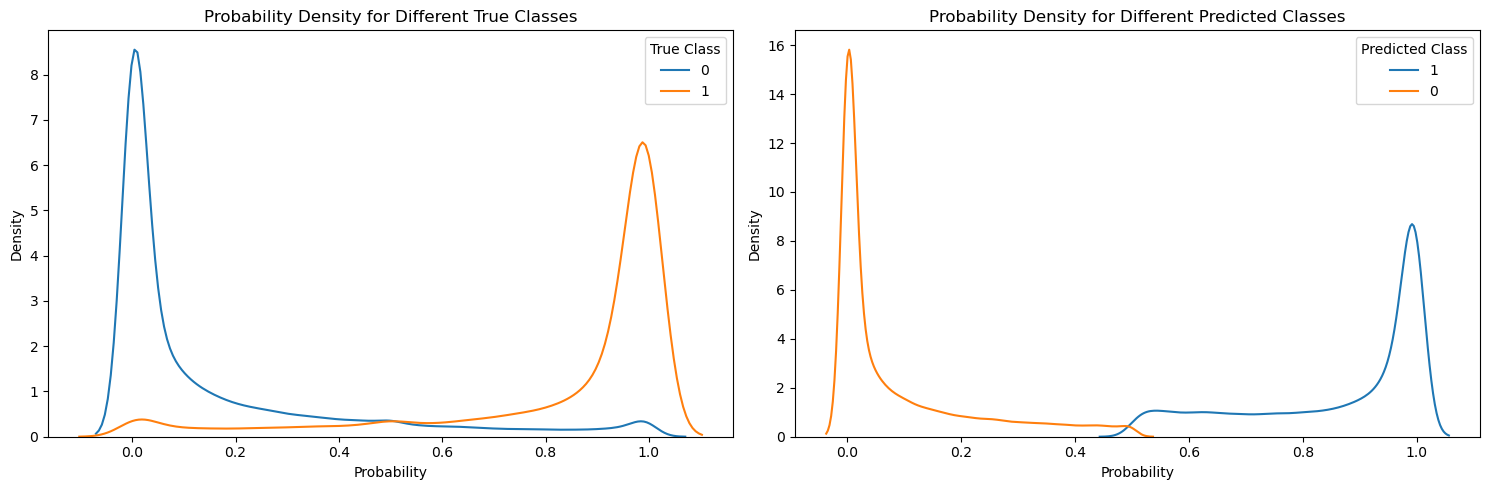

In [8]:
# get the results
y_pred = clf.predict(X_dev_transformed.toarray())
y_pred_proba = clf.predict_proba(X_dev_transformed.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

In [9]:
feature_log_prob = clf.feature_log_prob_
feature_importance = np.exp(feature_log_prob)
mask = selector.get_support() #list of booleans for selected features
new_features = [feature for bool, feature in zip(mask, loaded_vectorizer.get_feature_names_out()) if bool] # The list of your K best features

In [10]:
df_feature_importance = pd.DataFrame({
    'n-gram token': new_features,
    'Importance': feature_importance[1]  # assuming binary classification; change index for multiclass
})

df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)


In [11]:
import altair as alt

# Plot with Altair
chart = alt.Chart(df_feature_importance.head(25)).mark_bar().encode(
    x='Importance',
    y=alt.Y('n-gram token', sort='-x')
).properties(
    title='Most Important 50 Tokens'
)

chart

alt.Chart(...)

In [14]:
print(df_feature_importance.head(100)['n-gram token'].to_list())

['credit report', 'thi debt', 'thi compani', 'collect agenc', 'thi account', 'debt collector', 'debt collect', 'debt wa', 'collect debt', 'credit bureau', 'attempt to collect', 'alleg debt', 'phone call', 'origin creditor', 'phone number', 'credit card', 'tri to collect', 'never receiv', 'collect compani', 'account wa', 'portfolio recoveri', 'wa told', 'thi collect', 'receiv ani', 'thi wa', 'receiv letter', 'collect account', 'disput thi', 'collect practic', 'wa paid', 'debt collect practic', 'receiv call', 'cell phone', 'fair debt', 'call back', 'owe thi', 'debt valid', 'thi matter', 'year ago', 'ceas and desist', 'fair debt collect', 'account number', 'compani ha', 'stop call', 'medic bill', 'practic act', 'fair debt collect practic', 'sever time', 'thi alleg', 'remov from my credit', 'attempt to collect debt', 'report agenc', 'collect practic act', 'debt collect practic act', 'credit file', 'paid in full', 'report thi', 'wa sent', 'would like', 'wa never', 'say owe', 'person inform'

In [13]:
histogram = alt.Chart(df_feature_importance.head(5000)).mark_bar().encode(
    alt.X("Importance:Q", bin=alt.Bin(maxbins=100)),  # Adjust maxbins as needed
    y='count()',
).properties(
    title='Importantance Distribution of Top 5000 n-gram Tokens'
)

histogram

alt.Chart(...)

Ablation analysis is a method used to measure the effect of each feature on the model's performance. It involves training the model multiple times, each time with one feature removed, and then measuring the decrease in performance. This means that if you have 25,000 features, you would need to train the model 25,000 times to complete the ablation analysis. This can be computationally expensive and time-consuming.

Considering that the maximum importance of your features is relatively low (0.006), it suggests that your model's decisions are based on a combination of many features rather than a few highly important ones. In such a case, ablation analysis may not provide very insightful information as removing any single feature might not have a significant impact on the model's performance.

In conclusion, considering the computational cost and the likely minimal impact of each individual feature, running an ablation analysis for your current model may not be worthwhile.